In [1]:
import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import xclim as xc
import cftime
import seaborn as sns

## CORDEX

In [2]:
def read_data(var):
    hist_files = sorted(glob.glob(f'/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/day/{var}/latest/{var}_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_day_*.nc'))
    ssp370_files = sorted(glob.glob(f'/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/{var}/latest/{var}_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_*.nc'))
    cordex_files = hist_files + ssp370_files
    ds_cordex = xr.open_mfdataset(cordex_files)
    ds_cordex = ds_cordex.sel({'lat': -34.92, 'lon': 138.62}, method='nearest')
    ds_cordex = ds_cordex.compute()

    return ds_cordex

In [3]:
ds_pr = read_data('pr')

In [4]:
ds_pr['pr']

<xarray.DataArray 'pr' (time: 51500)> Size: 412kB
array([1.60187483e-07, 9.83476639e-07, 3.55392694e-06, ...,
       3.72529030e-09, 4.38518822e-04, 2.75671482e-07], shape=(51500,))
Coordinates:
  * time     (time) datetime64[ns] 412kB 1960-01-01T12:00:00 ... 2100-12-31T1...
    lat      float64 8B -34.88
    lon      float64 8B 138.6
Attributes:
    long_name:      Precipitation
    standard_name:  precipitation_flux
    units:          kg m-2 s-1
    cell_methods:   time: mean (interval: 1 hour) time: mean (interval: 1D)
    grid_mapping:   crs

In [5]:
pr_ann = ds_pr['pr'].resample({'time': 'YE'}).mean('time', keep_attrs=True)

In [6]:
pr_ann = pr_ann.compute()

In [7]:
ds_evspsblpot = read_data('evspsblpot')

In [8]:
ds_evspsblpot['evspsblpot']

<xarray.DataArray 'evspsblpot' (time: 51500)> Size: 412kB
array([2.47187912e-04, 2.04168260e-04, 9.21115279e-05, ...,
       4.78621572e-04, 4.22358513e-04, 2.81069428e-04], shape=(51500,))
Coordinates:
  * time     (time) datetime64[ns] 412kB 1960-01-01T12:00:00 ... 2100-12-31T1...
    lat      float64 8B -34.88
    lon      float64 8B 138.6
Attributes:
    long_name:      Potential Evapotranspiration
    standard_name:  water_potential_evaporation_flux
    units:          kg m-2 s-1
    cell_methods:   time: mean (interval: 1 hour) time: mean (interval: 1D)
    grid_mapping:   crs

In [9]:
evspsblpot_ann = ds_evspsblpot['evspsblpot'].resample({'time': 'YE'}).mean('time', keep_attrs=True)

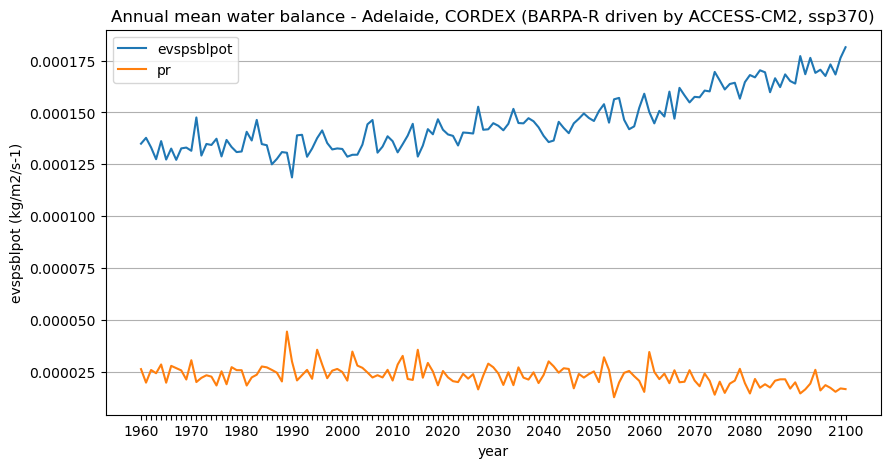

In [10]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()
ax.plot(evspsblpot_ann.time.dt.strftime('%Y').values, evspsblpot_ann.values, label='evspsblpot')
ax.plot(pr_ann.time.dt.strftime('%Y').values, pr_ann.values, label='pr')
ax.set_ylabel('evspsblpot (kg/m2/s-1)')
ax.set_xlabel('year')
ax.set_title('Annual mean water balance - Adelaide, CORDEX (BARPA-R driven by ACCESS-CM2, ssp370)')
ax.legend()
plt.grid(axis='y')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 10) != 0:
        t.set_visible(False)
plt.show()

In [11]:
wb = ds_pr['pr'] - ds_evspsblpot['evspsblpot']

In [12]:
wb.attrs['units'] = ds_pr['pr'].attrs['units']

In [13]:
da_spei = xc.indices.standardized_precipitation_evapotranspiration_index(
    wb, freq='MS', window=12, cal_start='1950-01-01', cal_end='2014-12-31', dist='fisk'
)   

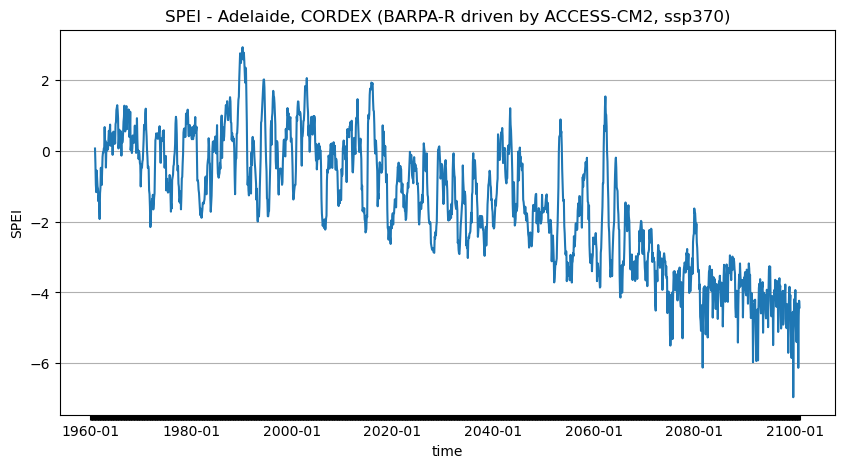

In [14]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()
ax.plot(da_spei.time.dt.strftime('%Y-%m').values, da_spei.values)
ax.set_ylabel('SPEI')
ax.set_xlabel('time')
ax.set_title('SPEI - Adelaide, CORDEX (BARPA-R driven by ACCESS-CM2, ssp370)')
plt.grid(axis='y')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 240) != 0:
        t.set_visible(False)
plt.show()